В этой работе нам предстоит с помощью encoder-decoder архитектуры, пробуя различные ее реализации, решить задачу машинного перевода.

#### Наша задача - сделать свой собственный переводчик!

Пока что только русско-английский:) Будем учиться на текстах описания отелей

С токенезацией хорошо справится WordPunctTokenizer из библиотеки nltk, а вот с кодированием не все так просто, как может показаться... 

В наших текстах очень много редких и очень мало встречаемых слов (в каждом отеле есть своя фишка: какой-то предмет декорации или услуга, которая описывается своим словом, которое только там и встречается). Если мы будем кодировать все слова, то размер нашего словаря будет очень-очень большим.

Можно кодировать побуквенно, кажется, что тут это может помочь! Да, действительно так, но придется очень очень долго обучать модель, а путешествовать и выбрать хороший отель уже хочется, поэтому мы придем к чему-то среднему между этими подходами -  [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) известный как __BPE__

Этот алгоритм стартует с посимвольного уровня и итеративно мерджит самые встречаемые пары. И так N итераций. На выходе мы получаем самые частые последовательности символов из которых формируются слова!

In [1]:
!pip install subword_nmt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# разбиваем и токенизируем тексты, записываем обработанные токены в файл
with open('train.en', 'w', encoding='utf-8') as f_src,  open('train.ru', 'w', encoding='utf-8') as f_dst:
    for line in open('data.txt', encoding='utf-8'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# строим и применяем bpe кодирование
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang, encoding='utf-8'), open('bpe_rules.' + lang, 'w', encoding='utf-8'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang, encoding='utf-8'))
    
    with open('train.bpe.' + lang, 'w', encoding='utf-8') as f_out:
        for line in open('train.' + lang, encoding='utf-8'):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:13<00:00, 589.42it/s]


### Построение словарей, разбиение данных

Сейчас, когда мы обучили BPE алгоритм на наших данных, построим словарь соответствия токена и его индекса, чтобы нам было затем удобно смотреть переводы и переводить новые предложения

Также сделаем разбиение на train/test

In [3]:
import numpy as np

In [4]:
data_inp = np.array(open('./train.bpe.ru', encoding='utf-8').read().split('\n'))
data_out = np.array(open('./train.bpe.en', encoding='utf-8').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [5]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [6]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


В коде ниже мы представили шаблон простой encoder-decoder модели, без всяких наворотов с Attention или чем-нибудь еще.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
class BaseModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__() 

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, inp, out):
        """ Сначала примените  encode а затем decode"""
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.dropout(self.emb_inp(inp))
        inp_emb.to(device)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dropout(self.dec_start(last_state))
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и 
        логиты для следующих токенов
        """
        prev_gru0_state = prev_state[0]
        
        prev_emb = self.dropout(self.emb_out(prev_tokens))
        prev_emb.to(device)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state)
        output_logits = self.dropout(self.logits(new_dec_state))
        
        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # первый символ всегда BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        # в цикле делаем decode_step, получаем logits_sequence
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Генерим токены для перевода """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        """Функция для перевода"""
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

In [ ]:
inp_voc.to_matrix(train_inp[0:4])

tensor([[   0, 4650, 7015, 4957, 1967, 7658, 5335,   29,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1],
        [   0, 4005, 7065,   25, 2140,  101, 4515, 7513, 6031, 4532, 1915, 3442,
         6204,   29,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1],
        [   0, 5197, 1186,  916,  660,  517, 6116, 2140, 7597, 4570, 3119, 3442,
           25, 2140,  131, 4488, 5161, 2607, 5508, 2665, 3442, 3726, 6573,   29,
            1],
        [   0, 2140, 6132, 2691, 6913, 2171, 3851, 6312, 2173, 3478, 3052,   29,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1]])

In [9]:
# debugging area
model = BaseModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [10]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
pensi@@ gulf canton@@ cup drive gau@@ supp@@ inv@@ lie interstate tle 8 ges usian housing alan@@ lement tor@@ door@@ atlantic tobogg@@ if cun cun hotell
skop@@ blanca würzburg airy 27 fantastic adv@@ chi@@ rose ago choice selling champs lyon parad@@ condo kas@@ is bo@@ by nightclub people water@@ fus@@ otel
newly times fo@@ krist@@ tended wild@@ 88 piazz@@ number sightseeing agen wai@@ agen cities function ws anim@@ rent@@ function в kitchens cottage boats airy loun@@


Нужно написать лосс, чтобы все училось:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

где $|D|$ это суммарная длина всех предложений включая все токены: BOS, EOS но не включая падинг 

In [11]:
def loss_function(model, inp, out, **flags):
    """
    Функция для подсчета лосса
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    Для того чтобы пройти тесты, ваша функция должна
    * учитывать в loss первый EOS, но НЕ учитывать последующие
    * разделить loss на длину входящей последовательности (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)
    
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities всех токенов на всех шагах
    logprobs_seq = F.log_softmax(logits_seq, dim=-1) # [batch_size, out_len, num_tokens]
   
    # log-probabilities для верных ответов
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1) # [batch_size, out_len]
    # нужно обойтись только векторными операциями без for

    # cross-entropy по всем токенам где mask == True
    return -logp_out[mask].mean() # тут должен получиться скаляр!

In [ ]:
dummy_loss = loss_function(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1)

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.4989, grad_fn=<NegBackward0>)


In [ ]:
model(dummy_inp_tokens, dummy_out_tokens).size()

torch.Size([5, 7, 7801])

### Метрика: BLEU

Для оценки машинного перевода обычно используется метрика [BLEU](https://en.wikipedia.org/wiki/BLEU). Она просто считает кол-во правильно предсказанных n-grams для n=1,2,3,4 и потом берет геометрическое среднее для полученных значений.

In [12]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    пример как считать метрику BLEU. Вы можете изменять вход и выход, 
    как вам удобно, главное оставьте логику ее подсчета!!!
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.0027130059512589827

Пока что BLEU почти нулевой (так как это в процентах)

### Training loop

In [13]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
# Определяем один шаг обучения и валидации

def train(model, optimizer):
    model.train()
    losses_tr = []
    for i in range(0, len(train_inp), batch_size):
        inp = inp_voc.to_matrix(train_inp[i:i+batch_size]).to(device) # Берем batch_size объектов
        out = out_voc.to_matrix(train_out[i:i+batch_size]).to(device)
        optimizer.zero_grad()
        loss = loss_function(model, inp, out) # Считаем наш лосс
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

def val(model):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for i in range(0, len(dev_inp), batch_size):
            inp = inp_voc.to_matrix(dev_inp[i:i+batch_size]).to(device)
            out = out_voc.to_matrix(dev_out[i:i+batch_size]).to(device)
            loss = loss_function(model, inp, out)

            losses_val.append(loss.item())
    
    return np.mean(losses_val)

In [14]:
import matplotlib.pyplot as plt

In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Теперь определяем функцию обучения, в которой по сути epoch раз запускается
# шаг обучения/валидации, а также рисуются графики
def learning_loop(
    model,
    optimizer,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    reduce_lr_every=5
):
    metrics = {'train_loss': [], 'val_loss': [], 'val_bleu': []}

    for epoch in range(1, epochs+1):
        
        # Уменьшаем длину шага в 4 раза раз в reduce_lr_every эпох
        if epoch % reduce_lr_every == 0:
            for g in optimizer.param_groups:
                g['lr'] = 2.5e-4
                
        print(f'#{epoch}/{epochs}:')
        
        # Шаг обучения
        model, optimizer, loss = train(
            model,
            optimizer
        )
        metrics['train_loss'].append(loss)

        # Шаг валидации
        if not (epoch % val_every):
            loss = val(model)
            metrics['val_loss'].append(loss)
            metrics['val_bleu'].append(compute_bleu(model, dev_inp, dev_out))
            if scheduler:
                scheduler.step(loss)

        # Рисуем графики
        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(121)
            plt.title('losses')
            plt.plot(metrics['train_loss'], 'r.-', label='train_loss')
            plt.legend()

            plt.plot(metrics['val_loss'], 'g.-', label='val_loss')
            plt.legend()

            plt.subplot(122)
            plt.title('bleu')

            plt.plot(metrics['val_bleu'], 'm.-', label='val_bleu')
            plt.legend()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, metrics

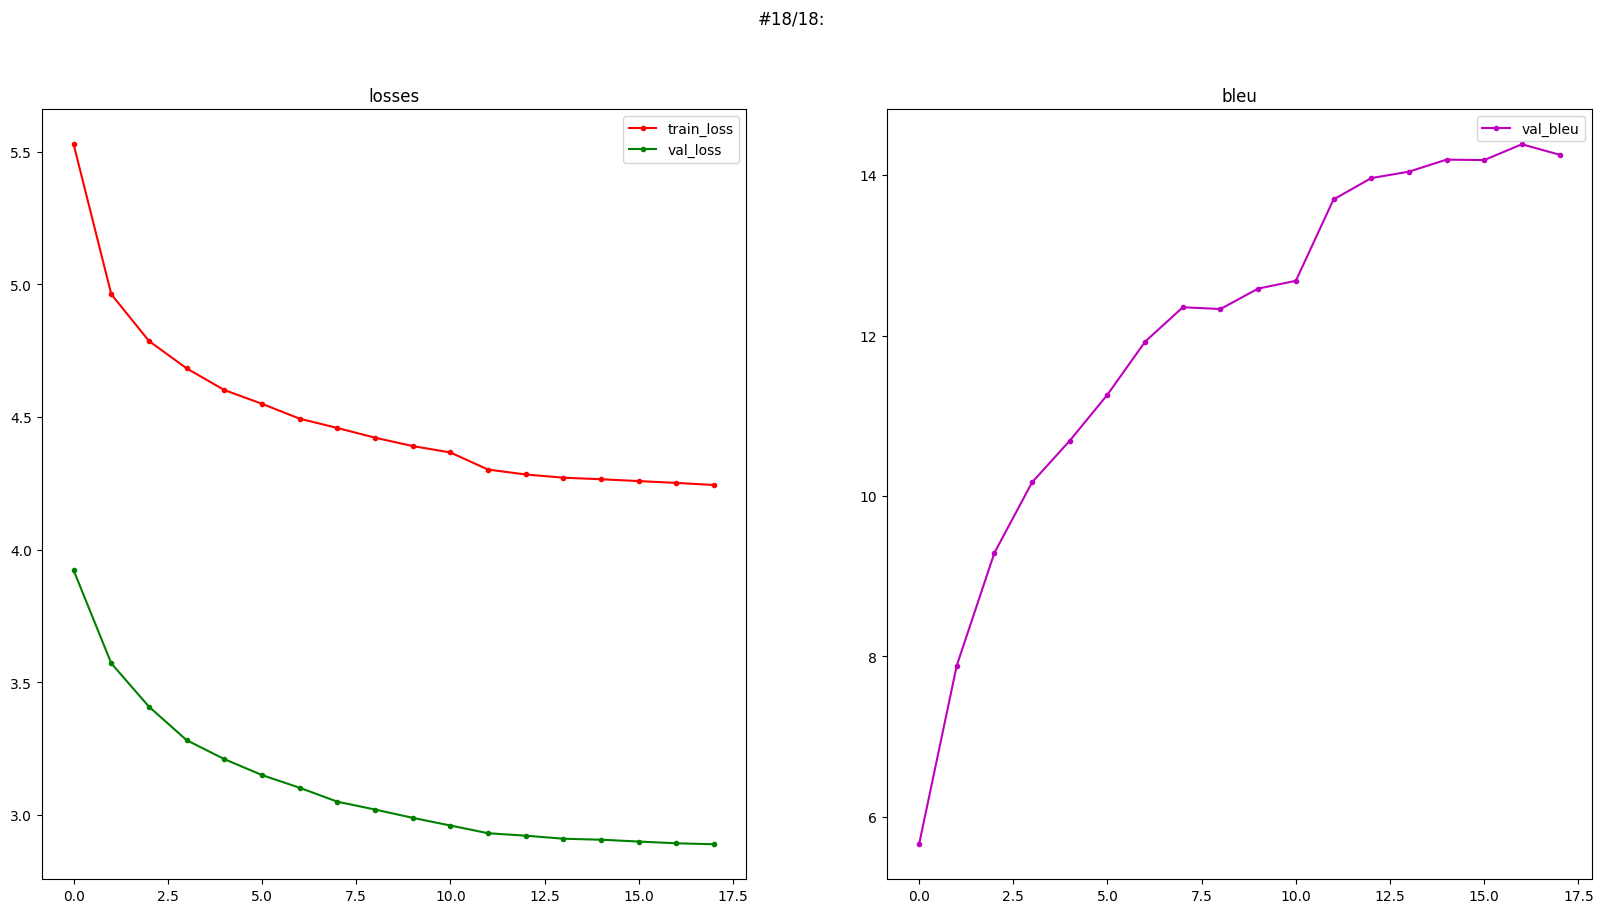

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm, trange

model = BaseModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

# Запустим сначала на 18 эпох с уменьшением шага на 12-ой эпохе
model, opt, metrics = learning_loop(
    model = model,
    optimizer = opt,
    epochs = 18,
    min_lr = 2e-6,
    reduce_lr_every = 12
)

Не успели подняться выше 15 по BLEU, поэтому вернем длину шага и обучим еще 6 эпох

In [ ]:
for g in opt.param_groups:
    g['lr'] = 1e-3

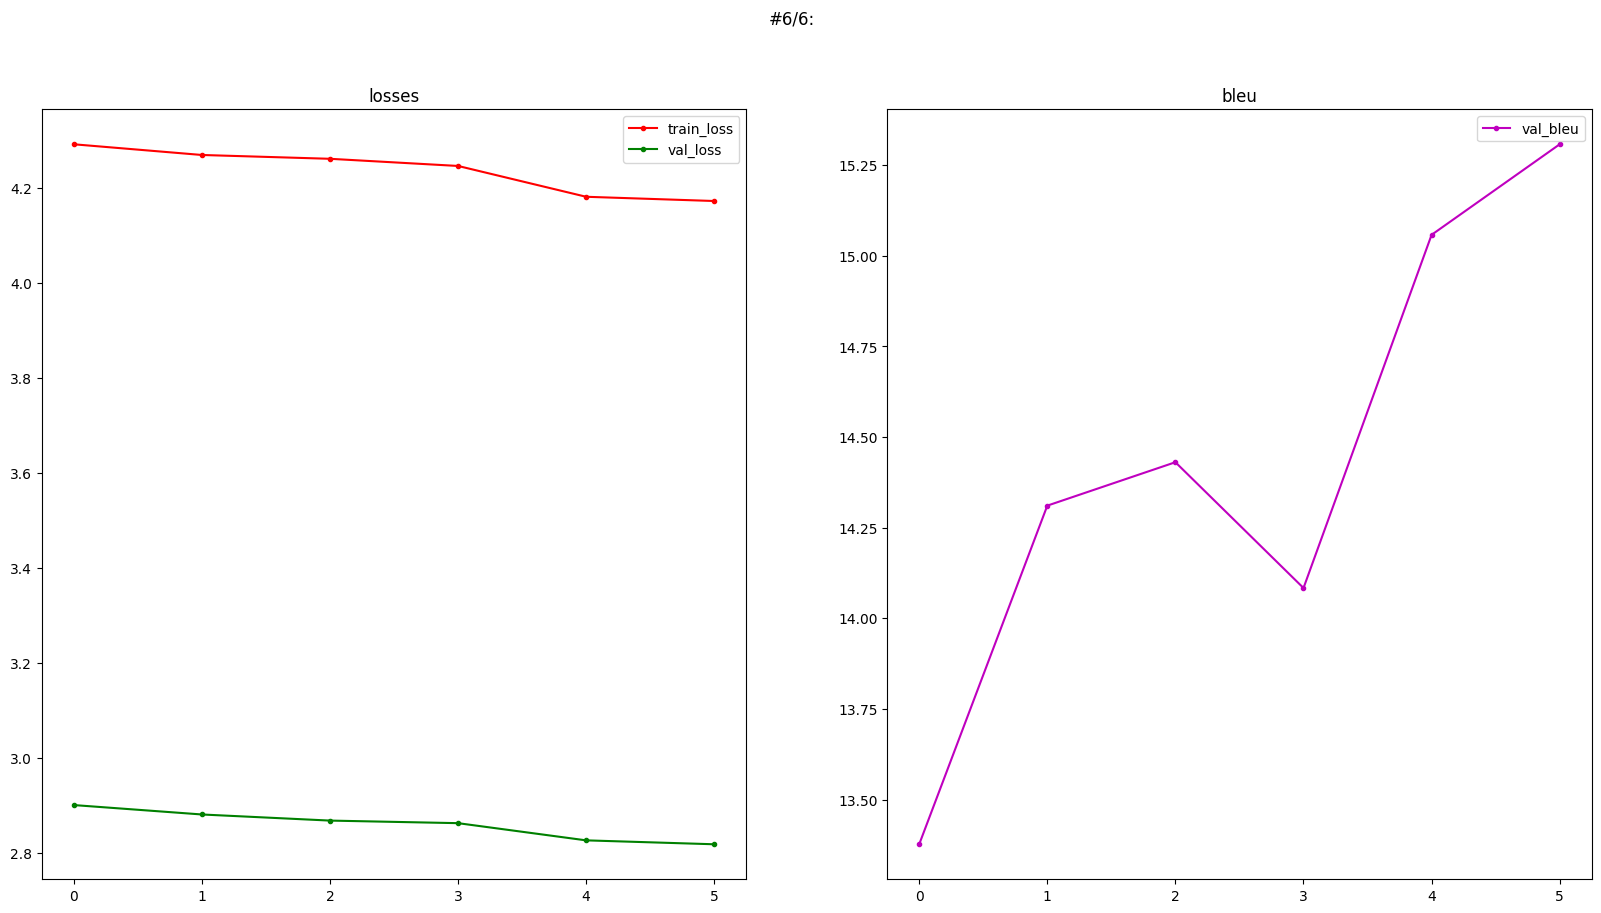

In [ ]:
model, opt, metrics = learning_loop(
    model = model,
    optimizer = opt,
    epochs = 6,
    min_lr = 2e-6
)

In [ ]:
assert metrics['val_bleu'][-1] > 15
print("Все получилось!")

Все получилось!


In [ ]:
metrics['val_bleu'][-1]

15.307283127106624

In [ ]:
i = 0
for inp_line, trans_line in zip(train_inp[::500], model.translate_lines(train_inp[::500])[0]):
    i += 1
    print(inp_line)
    print(trans_line)
    print()
    if i == 6:
        break

на территории обустроена бесплатная частная парковка .
free private parking is available on site .

гости могут посетить ресторан на крыше , откуда открывается панорамный вид на форт джай@@ сал@@ мер и город .
guests can enjoy the on - site restaurant and the restaurant can be enjoyed on site .

в числе удобств 6 спален , телевизор с плоским экраном , просторная гостиная зона и терраса .
the accommodation will provide you with a flat - screen tv , a seating area and a kitchen .

комплекс апартаментов с собственной кухней residence gi@@ o@@ i@@ o@@ sa mar@@ ea находится в коммуне джо@@ йо@@ за - ма@@ ре@@ а .
apartment on the terrace is located in the heart of the city of the city .

расстояние до гольф - клуба jam@@ es river составляет 10 , 4 км .
the golf course is 2 . 5 km away .

гости могут отдохнуть у камина в лаундже или заказать в баре разнообразные но@@ воз@@ ел@@ анд@@ ские вина .
guests can enjoy the on - site bar or enjoy a drink at the bar .



In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen at the property .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
the property offers free parking and a private parking .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the property is 11 km from the property .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located in the centre of the city , this air - conditioned apartment features a garden , a terrace and a terrace .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
located in the heart of the city , this apartment is located in the heart of the city .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a shower , private bathrooms also come with a hairdryer .



В целом, не так плохо, как минимум видим релевантные английские слова в переводе. Но при этом перевод не совсем осмысленный, все-таки связь слов внутри предложений теряется. Нужно как-то улучшать

## Attention is all you need


В этом разделе мы хотим усовершенствовать базовую модель

Сначала напишем слой Attention, а потом внедрим его в уже существующий шаблон

### Attention layer

На вход подается скрытые состояния encoder $h^e_0, h^e_1, h^e_2, ..., h^e_T$ и предыдущие состояние декодера $h^d$,

* Считаем логиты:
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получаем вероятности из логитов: 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвешиваем состояния энкодера с полученными вероятностями
$$ attn = \sum_t p_t \cdot h^e_t $$


In [19]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        super().__init__()
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 
        
        # опишите все слои, которые нужны Attention
        self.linear_e = nn.Linear(enc_size, hid_size)
        self.linear_d = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1, bias=False)

    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ and веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
        """

        # считаем логиты
        logits = self.linear_out(torch.tanh(self.linear_e(enc) + self.linear_d(dec).unsqueeze(1)))

        logits = logits.squeeze(-1)
        # Применим маску - если значение маски 0, логиты должны быть -inf или -1e9
        # Лучше использовать torch.where
        logits = torch.where(inp_mask == 0, torch.full_like(logits, -1e9), logits)

        # Применим softmax
        probs = F.softmax(logits, dim=-1)

        # Подсчитаем выход attention используя enc состояния и вероятностями
        attn = torch.sum(enc * probs.unsqueeze(-1), dim=1)

        return attn, probs

### Seq2seq model with attention 

Теперь мы можем использовать уровень внимания для построения сети. Самый простой способ реализовать внимание - использовать его на этапе декодирования:


На каждом шаге используем предыдущее состояние декодера, и написанный слой Attention




In [17]:
class AttentiveModel(BaseModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """Переводчик с Attention"""
        nn.Module.__init__(self)
        # Все как в BaseModel (ну почти, только размерности другие)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size + attn_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        self.dropout = nn.Dropout(0.3)
    
        # Вот только добавляем attention
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)

    def encode(self, inp, **flags):
        """
        Считаем скрытые скрытые состояния, которые используем в decode
        :param inp: матрица входных токенов
        """
        
        # делаем encode
        inp_emb = self.dropout(self.emb_inp(inp))
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        
        dec_start = self.dropout(self.dec_start(last_state))
        
        mask = (inp != self.inp_voc.eos_ix).to(torch.int64)
        # apply attention layer from initial decoder hidden state
        # применяем attention слой для скрытых состояний
        first_attn_probas = self.attention(enc_seq, dec_start, mask)[0]
        
        # Для декодера нужно вернуть:
        # - начальное состояние для RNN декодера
        # - последовательность скрытых состояний encoder, maskа для них
        # - последним передаем вероятности слоя attention
        
        first_state = [dec_start, enc_seq, mask, first_attn_probas]
        return first_state
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логиты для следующих токенов
        :param prev_state: список тензоров предыдущих состояний декодера
        :param prev_tokens: предыдущие выходные токены [batch_size]
        :return: список тензоров состояния следующего декодера, тензор логитов [batch, n_tokens]
        """
        
        prev_gru0_state = prev_state[0]
        prev_attn_probas = prev_state[3]
        mask = prev_state[2]
        enc_seq = prev_state[1]
        
        prev_emb = self.dropout(self.emb_out(prev_tokens))
        prev_emb.to(device)
        
        rnn_input = torch.cat([prev_emb, prev_attn_probas], dim=-1)
        new_dec_state = self.dec0(rnn_input, prev_gru0_state)
        output_logits = self.dropout(self.logits(new_dec_state))
        
        attn_probas = self.attention(enc_seq, new_dec_state, mask)[0]
        dec_state = [new_dec_state, enc_seq, mask, attn_probas]
        return dec_state, output_logits

### Обучение модели 

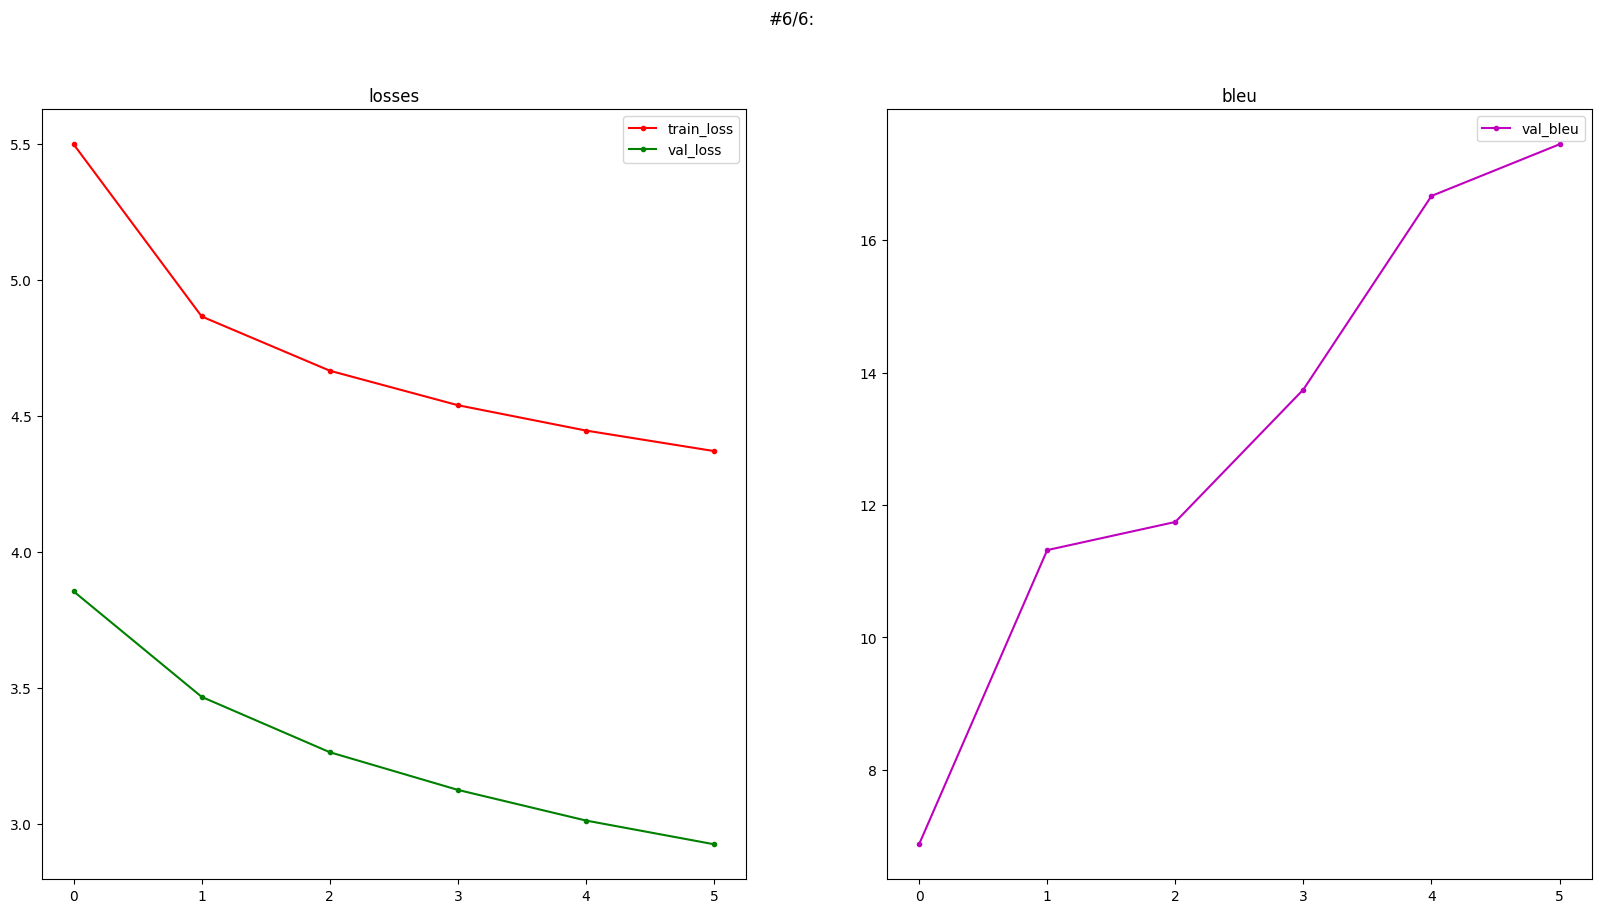

In [20]:
from IPython.display import clear_output
from tqdm import tqdm, trange

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

model, opt, metrics = learning_loop(
    model = model,
    optimizer = opt,
    epochs = 6,
    min_lr = 2e-6,
    reduce_lr_every = 12
)

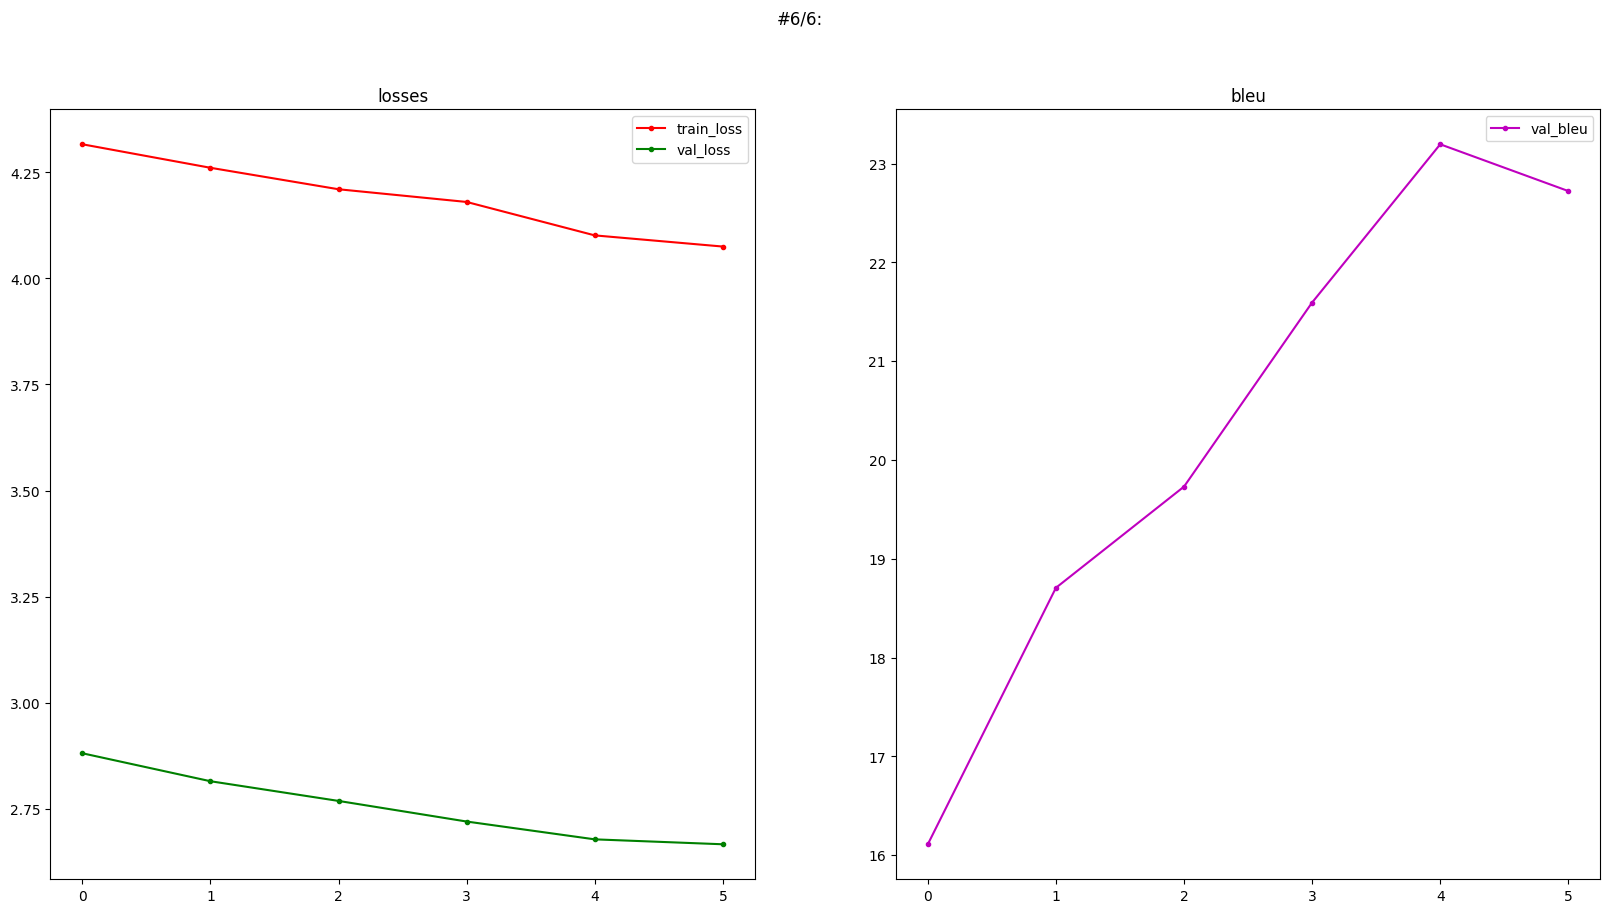

In [21]:
# Так, ну динамика отличная, гораздо быстрее растет bleu, чем у нас было раньше, но нужно еще немного обучить

model, opt, metrics = learning_loop(
    model = model,
    optimizer = opt,
    epochs = 6,
    min_lr = 2e-6
)

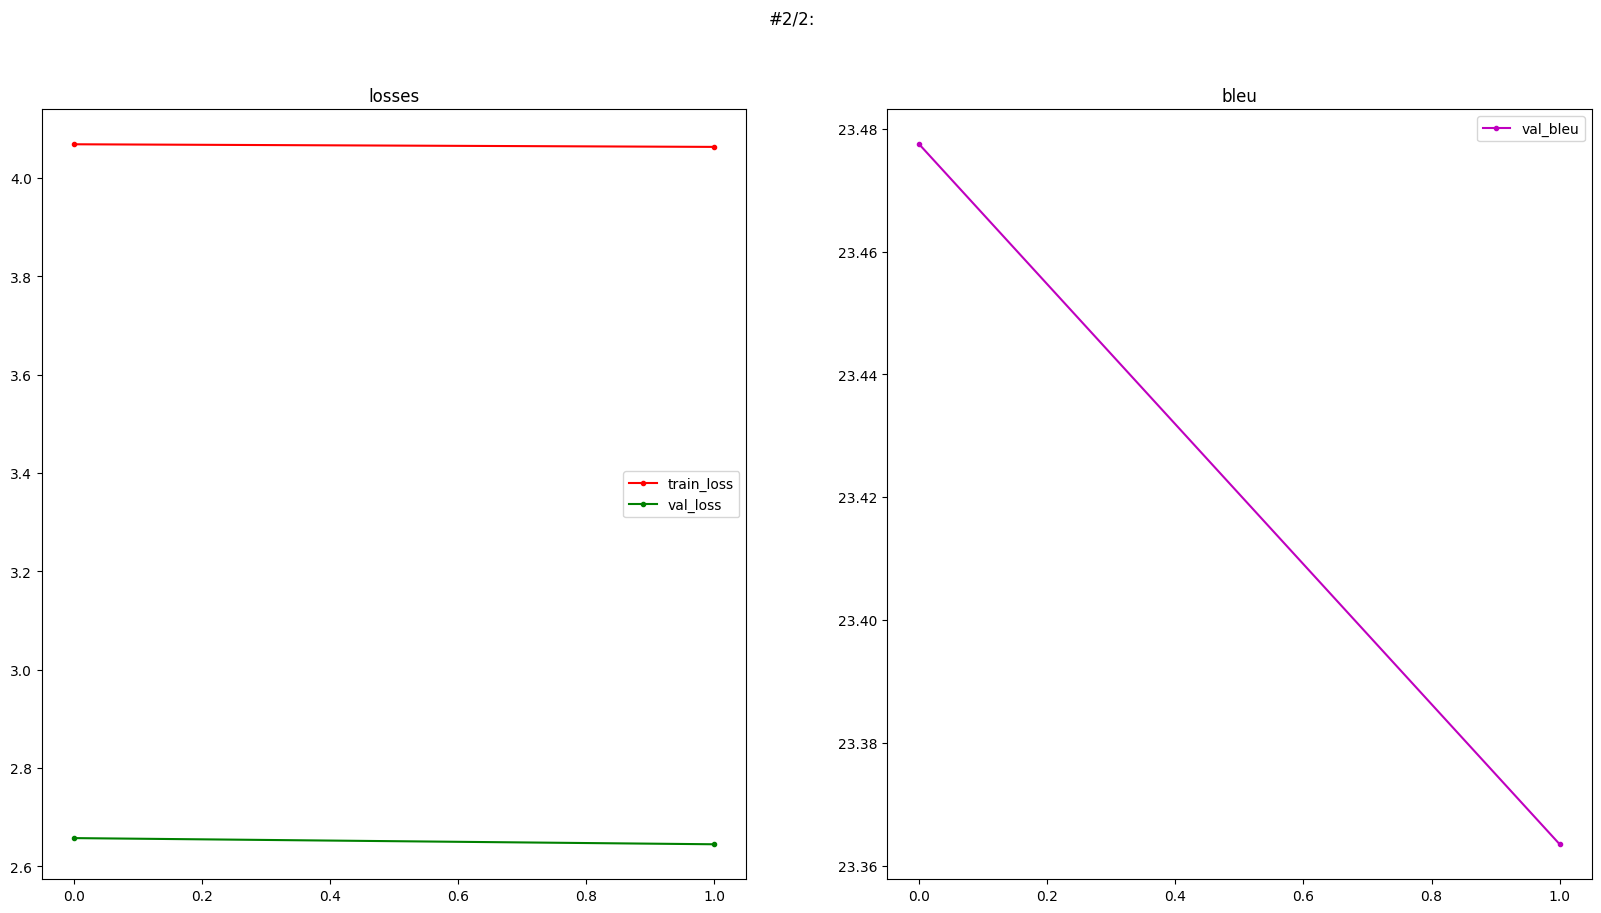

In [22]:
# Черт, на последней эпохе упало ниже 23, хотя было больше, обучаем еще две эпохи)

model, opt, metrics = learning_loop(
    model = model,
    optimizer = opt,
    epochs = 2,
    min_lr = 2e-6
)

In [23]:
assert metrics['val_bleu'][-1] > 23
print("Все получилось!")

Все получилось!


In [24]:
metrics['val_bleu'][-1]

23.363478893396923

In [25]:
i = 0
for inp_line, trans_line in zip(train_inp[::500], model.translate_lines(train_inp[::500])[0]):
    i += 1
    print(inp_line)
    print(trans_line)
    print()
    if i == 6:
        break

на территории обустроена бесплатная частная парковка .
free private parking is available on site .

гости могут посетить ресторан на крыше , откуда открывается панорамный вид на форт джай@@ сал@@ мер и город .
guests can enjoy the on - site restaurant , which overlooks the mediterranean sea and the city .

в числе удобств 6 спален , телевизор с плоским экраном , просторная гостиная зона и терраса .
the accommodation will provide you with a flat - screen tv , a seating area and a terrace .

комплекс апартаментов с собственной кухней residence gi@@ o@@ i@@ o@@ sa mar@@ ea находится в коммуне джо@@ йо@@ за - ма@@ ре@@ а .
offering a private entrance , apartments at the azzur@@ la di das di is located in the centre of santa maria .

расстояние до гольф - клуба jam@@ es river составляет 10 , 4 км .
the property is 10 . 4 km from the property .

гости могут отдохнуть у камина в лаундже или заказать в баре разнообразные но@@ воз@@ ел@@ анд@@ ские вина .
guests can relax in the lounge or relax

In [26]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen at the property and there is a shared kitchen at the property .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
the property offers bike rental , a shuttle service and free parking .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the town of kotor is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located a 5 - minute walk from the beach in the centre of playa del carmen , this air - conditioned unit features a garden and a terrace .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
apartment at san vito is located in rome , 200 metres from the cathedral .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a shower , private bathroom 

Уже значительно лучше, но видны некоторые недочеты в построении предложений

## Дообучим модель из huggingface

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Подгружаем предобученные токенайзер и модель
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en")

In [ ]:
from datasets import Dataset

In [ ]:
# Делаем листы словарей из данных, чтобы можно было это засунуть в Dataset

lst1 = []
lst2 = []

for i in range(len(train_inp)):
    dct = {}
    dct['id'] = i
    dct['translation'] = {}
    dct['translation']['ru'] = train_inp[i]
    dct['translation']['en'] = train_out[i]
    lst1.append(dct)
    
for i in range(len(dev_inp)):
    dct = {}
    dct['id'] = i
    dct['translation'] = {}
    dct['translation']['ru'] = dev_inp[i]
    dct['translation']['en'] = dev_out[i]
    lst2.append(dct)

In [ ]:
# Смотрим что получилось

train = Dataset.from_list(lst1)
train

Dataset({
    features: ['id', 'translation'],
    num_rows: 47001
})

In [ ]:
test = Dataset.from_list(lst2)
test

Dataset({
    features: ['id', 'translation'],
    num_rows: 3000
})

In [ ]:
import datasets

# Соединяем в единое целое
texts = datasets.DatasetDict({"train":train, "test":test})
texts

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 47001
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 3000
    })
})

In [ ]:
source_lang = "ru"
target_lang = "en"

# Токенизируем предложения

def preprocess_function(examples):
    inputs = [example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

tokenized_texts = texts.map(preprocess_function, batched=True)

Map:   0%|          | 0/47001 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
tokenized_texts['train']

Dataset({
    features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 47001
})

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="Helsinki-NLP/opus-mt-ru-en")

In [ ]:
import evaluate

metric = evaluate.load("sacrebleu")

In [ ]:
import numpy as np

# Функции для вывода метрик

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

In [ ]:
# Запускаем трейнер для fine-tuning'a модели

training_args = Seq2SeqTrainingArguments(
    output_dir="my_awesome_hotels_discription_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_texts["train"],
    eval_dataset=tokenized_texts["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,1.279500,1.145808,35.378600,26.998700


TrainOutput(global_step=2938, training_loss=1.4485200449591027, metrics={'train_runtime': 713.4766, 'train_samples_per_second': 65.876, 'train_steps_per_second': 4.118, 'total_flos': 1113328236625920.0, 'train_loss': 1.4485200449591027, 'epoch': 1.0})

Смотрим на переводы

In [ ]:
from transformers import pipeline
text = 'отель в 5км от аэропорта'

translator = pipeline("translation", model="my_awesome_hotels_discription_model/checkpoint-2500")
translator(text)

[{'translation_text': 'the hotel is 5 km from the airport .'}]

In [ ]:
for inp_line in train_inp[::6000]:
    print(inp_line)
    print(translator(inp_line)[0]['translation_text'])
    print()

на территории обустроена бесплатная частная парковка .
free private parking is available on site .

фермерский дом santa cro@@ ce с садом с принадлежностями для барбекю и детской игровой площадкой расположен в тихом месте , в 10 минутах езды от ф@@ ос@@ с@@ ат@@ о - ди - ви@@ ко .
featuring a garden with barbecue facilities and a children  s playground , santa cro@@ ce farmhouse is located in a quiet location , a 10 - minute drive from fos@@ ato di vico .

от экологи@@ чного отеля p@@ est@@ ana rio atlanti@@ ca до аэропорта сантос - дюмон — 8 км , а до аэропорта галеан — 20 км .
pest@@ ana rio atlantica is 8 km from santos dumont airport and 20 km from galeão airport .

гости пользуются общей ванной комнатой с душем и феном .
there is a shared bathroom with a shower and hairdryer .

кар@@ лов мост находится в 1 км от отеля , а расстояние до праж@@ ского аэропорта имени вацлав@@ а гав@@ ела составляет 11 км .
the car@@ v bridge is 1 km from the hotel , while va@@ zlav@@ a hav@@ el pragu

In [ ]:
for inp_line in dev_inp[::500]:
    print(inp_line)
    print(translator(inp_line)[0]['translation_text'])
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen and a shared living room .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bike hire , shuttle service and free parking are also available .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
kissi@@ m@@ mi is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
the penthouse offers a shared outdoor pool , garden , air conditioning and sun terrace , a 5 - minute walk from the beach at the ca@@ bo roy resort .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
mosco@@ w point - loft red square is located in moscow , 200 metres from the large theatre .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
there is a private bathroom with a shower and towels .

Очень неплохо. В предложениях уже видна связь между словами, почти весь смысл передается